In [4]:
import numpy as np
import pyedflib

import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from sklearn.model_selection import train_test_split, KFold
import random

# Choose EEG or EMG

In [5]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
#data_type = "EMG"

In [6]:
# choose individuum
subject = "m292"

# Import Data

In [19]:
label_list = [0, 1, 2, 3, 4]

In [20]:
# EEG & EMG data
data = {}

for label in label_list:
    data[label] = pd.read_csv("Data/"+str(subject)+"/run0"+str(label)+"/Time_Series_Data.csv")

# Preprocessing

## Segmenting Data

In [21]:
def segment_data(df, segment_size, step_size = 2):
    """
    Segments time-series data into EEG and EMG segments.

    Parameters:
    - df (DataFrame): The input dataframe containing the columns "Time", "EEG" and "EMG".
    - segment_size (float): The desired size of each segment in seconds.
    - step_size (float, optional): The step size of "Time" in milliseconds. Default is 2 millisecond.

    Returns:
    Tuple of two lists:
    - List of EEG segments.
    - List of EMG segments.
    """

    n_segments = int(df["time"].iloc[-1]) // segment_size
    eeg_segments = []
    emg_segments = []

    for i in range(n_segments):
        start_idx = int(i* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df.iloc[start_idx:end_idx]
        eeg_segments.append(list(segment["voltage"]))
        emg_segments.append(list(segment["emg"]))

    return eeg_segments, emg_segments

In [22]:
# Segment the data
segment_size = 4  # seconds
eeg_segments = {}
emg_segments = {}

for label in label_list:
    eeg_segments[label], emg_segments[label] = segment_data(data[label], segment_size, step_size = 2)

In [23]:
if data_type == "EEG":
    segments = eeg_segments
else:
    segments = emg_segments

In [24]:
def return_list_with_all_segments(segments, label_list):

    all_segments = list()
    
    for label in label_list:
        all_segments.extend(segments[label])

    return all_segments


all_segments = return_list_with_all_segments(segments, label_list)

# Compute Indices for Cross Validation and Final Test Set

### Choose parameters

In [25]:
# Choose size of final test set for classification at later step (recommended: 0.2-0.3)

test_size = 0.2

In [26]:
# Choose number of folds for Cross Validation of the training/validation data

n_folds = 5

### Choose Train and Test Data Indices for Test Set and for Each Fold

In [27]:
def choose_train_and_test_indices(segments, test_size):
    train_indices_dict = {}
    test_indices_dict = {}

    # Iterate through each label and perform train/test split
    for label, segments_values in segments.items():


        # Perform train/test split
        train_indices, test_indices = train_test_split(np.arange(len(segments_values)), test_size=test_size, random_state=32)


        # Store the split indices
        train_indices_dict["Label_"+str(label)] = train_indices
        test_indices_dict["Label_"+str(label)] = test_indices


    return train_indices_dict, test_indices_dict


# Choose train and test indices
train_indices_dict, test_indices_dict = choose_train_and_test_indices(segments, test_size)

In [28]:
def compute_train_and_validation_set_indices_for_cross_validation(label_list, segments, train_indices_dict, n_folds):
    
    # Initialize Cross Validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    train_indices_dict_for_folds = {}
    validation_indices_dict_for_folds = {}
    
    for label in label_list:
        label_key = "Label_" + str(label)
        
        # Initialize dictionary for each label
        train_indices_dict_for_folds[label_key] = {}
        validation_indices_dict_for_folds[label_key] = {}
        
        label_indices = train_indices_dict[label_key]
        
        # Use KFold only if there are enough samples for cross-validation
        if len(label_indices) >= 5:
            for fold, (train_indices, validation_indices) in enumerate(kf.split(label_indices)):
                train_indices_dict_for_folds[label_key][f"Fold_{fold}"] = label_indices[train_indices]
                validation_indices_dict_for_folds[label_key][f"Fold_{fold}"] = label_indices[validation_indices]
        else:
            # Handle case where fewer than 5 samples are available
            for fold in range(len(label_indices)):
                train_indices_dict_for_folds[label_key][f"Fold_{fold}"] = [label_indices[fold]]
                validation_indices_dict_for_folds[label_key][f"Fold_{fold}"] = [label_indices[fold]]

            # Fill in remaining folds with empty lists if needed
            for remaining_fold in range(len(label_indices), n_folds):
                train_indices_dict_for_folds[label_key][f"Fold_{remaining_fold}"] = []
                validation_indices_dict_for_folds[label_key][f"Fold_{remaining_fold}"] = []
    
    return train_indices_dict_for_folds, validation_indices_dict_for_folds


train_indices_dict_for_folds, validation_indices_dict_for_folds = compute_train_and_validation_set_indices_for_cross_validation(label_list,
                                                                                    segments, train_indices_dict, n_folds)

# Preprocessing

## Find outliers

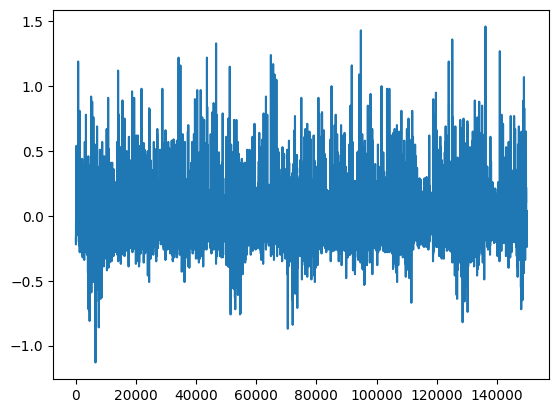

In [29]:
import matplotlib.pyplot as plt

label_to_check = 0

plt.plot(data[label_to_check]["voltage"])

From a visual check, we concluded that there are no outliers.

## Optional

This is how we would detect outliers (if there were any).

In [31]:
def concatenate_segments_for_each_label(label_list, segments):

    # Save the segments of each label for finding outliers

    label_segments = {} # Addionally 
    time_series_per_label = {}

    for label in label_list:
        ts_segments = []
        time_series = []
        for sgmt in segments[label]:   
            # Later use for finding outliers
            ts_segments.append(sgmt) # segment
            time_series.extend(sgmt) # flat TS

        label_segments[label] = ts_segments
        time_series_per_label[label] = time_series

    
    # Additionally save all segments together
    all_segments = np.array([])
    
    for label in label_list:
        all_segments = np.append(all_segments, segments[label])

    return label_segments, time_series_per_label, all_segments


label_segments, time_series_per_label, all_segments = concatenate_segments_for_each_label(label_list, segments)

In [32]:
def detect_artifacts(segments_of_our_label, all_segments, threshold):
    
    # Calculate the mean and standard deviation of the maximum absolute value in each segment
    # of all time series

    all_mav = []  # maximal absolute values of all segments
    
    for segment in all_segments:
        all_mav.append(np.max(np.abs(segment)))

    mean = np.mean(all_mav)
    std = np.std(all_mav)

    mav_of_our_label = [] # maximal absolute values of all segments of our labels
    
    for segment in segments_of_our_label:
        mav_of_our_label.append(np.max(np.abs(segment)))
    
    # Calculate the Z-scores for each data point
    z_scores = (mav_of_our_label - mean) / std
          
    # Find data points with Z-scores above the threshold (outliers)
    outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

    return outliers_indices

In [33]:
outlier_indices = {}

# Threshold has to be set correctly such that we obtain the wished number of outliers
# (zero in this case)
for label in label_list:
    outlier_indices[label] = detect_artifacts(segments[label], all_segments, threshold=17)

num_outliers = sum([len(outlier_indices[label]) for label in label_list]) 

In [36]:
# Save all indices

# Train indices
np.save("Train_Test_Splitting/"+str(subject)+"/Train_Indices_All_Labels_All_Folds.npy",\
    np.array(train_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Validation indices
np.save("Train_Test_Splitting/"+str(subject)+"/Validation_Indices_All_Labels_All_Folds.npy",\
    np.array(validation_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Final Test set indices
np.save("Train_Test_Splitting/"+str(subject)+"/Final_Test_Set_Indices_All_Labels.npy",\
    np.array(test_indices_dict, dtype=object), allow_pickle=True)



# Create Persistence Diagrams

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [37]:
# Initialise the embedding
max_embedding_dimension = 30
max_time_delay = 30
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [38]:
def find_optimal_parameters(embedder, segments, max_index, iterations = 8):
    """
    Finds (approximate) optimal embedding parameters by averaging optimal parameters of random segments.

    Parameters:
    - embedder (object): defined by SingleTakensEmbedding() or similar
    - segments (list of lists): Complete EEG/EMG segments
    - max_index (int): How many segments there are
    - iteratiors (int): How many random indices to sample

    Returns:
    Tuple of two floats:
    - Average optimal embedding dimension
    - Average optimal time delay
    """


    optimal_embeddings_dimensions = []
    optimal_time_delays = []
    
    for _ in range(iterations):
        random_index = random.randint(0, max_index)
        embedding = embedder.fit_transform(segments[random_index])
        
         # append optimal embedding dimension for this segment
        optimal_embeddings_dimensions.append(embedder.dimension_)

        # append optimal time delay for this segment
        optimal_time_delays.append(embedder.time_delay_)

        print("The optimal embedding dimension is " + str(np.mean(optimal_embeddings_dimensions)) + 
              " and the optimal time delay is " + str(np.mean(optimal_time_delays)))
        
        return int(np.mean(optimal_embeddings_dimensions)), int(np.mean(optimal_time_delays))

In [39]:
# Compute optimal embedding parameters

all_segments = []

for label in label_list:
    all_segments.extend(segments[label])
    
embedding_dimension, embedding_time_delay = find_optimal_parameters(embedder, all_segments, len(all_segments), iterations = 8)

The optimal embedding dimension is 6.0 and the optimal time delay is 30.0


## Creating Persistence Diagrams

In [40]:
# Setting parameters for point cloud embeddings

#embedding_dimension= 3 # for data exploration

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay, # computed above
    dimension=embedding_dimension, # computed above
    stride=stride,
)

In [41]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [42]:
def compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, label):

    time_delay_embeddings["Label_"+str(label)] = []
    persistence_diagrams["Label_"+str(label)] = []

    # Compute embeddings and diagrams for the complete data
    for diagram_idx in range(len(segments[label])):
        time_delay_embeddings["Label_"+str(label)].append(embedder.fit_transform(segments[label][diagram_idx])[None, :, :])
        persistence_diagrams["Label_"+str(label)].append(persistence.fit_transform(time_delay_embeddings["Label_"+str(label)][diagram_idx]))
    
    return time_delay_embeddings, persistence_diagrams

In [43]:
# Compute embeddings and persistence diagrams for the complete data

time_delay_embeddings = {}
persistence_diagrams = {}

for label in label_list:
    time_delay_embeddings, persistence_diagrams = compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, label)

## Create Extended Persistence Diagrams

We will need these for computing the Wasserstein barycenters.

In [44]:
def find_largest_dimension(persistence_diagrams, label_list):
    """
    Find the length of the longest list in a list of lists.

    Parameters:
    - persistence_diagrams (dictionary): List of persistence diagrams, with labels as keys.
    - label_list (list): List of all labels.

    Returns:
    - longest_lengths_each_dimension (dictionary): Highest amount of holes in a persistence diagram for each dimension.
    """

    # Initialize highest number of holes of each dimension for each label
    longest_lengths_each_dimension = {}
    for label in label_list:
        longest_lengths_each_dimension["Label_"+str(label)] = {}

        for hole_dim in range(3):
            longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)] = 0

    for label in label_list:

        # Only look at persistence diagrams of current label
        persistence_diagrams_with_label = persistence_diagrams["Label_"+str(label)]


        # For each hole dimension (between 0 and 2), find the largest amount of holes
        # of this dimension which there is in one of the persistence diagrams
        
        for hole_dim in range(3):

            # for the current hole dimension, count the amount of holes in each diagram
            for diagram in persistence_diagrams_with_label:
                current_number_of_holes_of_hole_dim = 0 # Initialize
                
                for hole in diagram[0]: # the holes are nested, so take diagram[0]
                    # only take those holes of the current hole dimension into account
                    # (the hole dimension is indicated by the 3rd entry of the hole)
                    if hole[2] == hole_dim:
                        current_number_of_holes_of_hole_dim += 1

                # If the amount of holes of the current diagram is higher than the 
                # previous highest number of holes, redefine the highest number
                if current_number_of_holes_of_hole_dim > longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)]:
                    longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)] = current_number_of_holes_of_hole_dim

    # Because this is what we want in this case, compute the overall longest dimensions which we will use for all labels
    longest_lengths_each_dimension_overall = {key: max(label_dict[key] for label_dict in longest_lengths_each_dimension.values())
    for key in ['Hole_Dim_0', 'Hole_Dim_1', 'Hole_Dim_2']}
    
    return longest_lengths_each_dimension_overall


In [45]:
longest_lengths_each_dimension_overall = find_largest_dimension(persistence_diagrams, label_list)

In [46]:
def extend_diagrams_to_largest_dimensions(persistence_diagrams, desired_lengths_each_dimension, label_list):
    """
    Extend all persistence diagrams to the largest dimension 
    by appending (0, 0, hole_dim) tuples.

    Parameters:
    - persistence_diagrams (dict): List of persistence_diagrams of each label.
    - longest_lengths_each_dimension_overall (dict): Contains the wished amount of holes for each dimension.
    - label_list (list): List of all labels.

    Returns:
    - extended_persistence_diagrams (dict): List of extended eprsistence_diagrams for each label.
    """

    # Initialize dictionary of extended persistence diagrams (with labels as keys)
    extended_persistence_diagrams = {}

    for label in label_list:

        # Initialize extended persistence diagrams for current label
        extended_persistence_diagrams["Label_"+str(label)] = []
        
        # Only look at persistence diagrams of current label
        persistence_diagrams_with_label = persistence_diagrams["Label_"+str(label)]

        # Extend each diagram to the highest number of holes for each dimension
        for diagram in persistence_diagrams_with_label:

            extended_diagram = list(diagram[0])
            
            for hole_dim in range(3):

                # the persistence diagrams are nested, so take diagram[0]                    
                current_number_of_holes_of_hole_dim = sum(1 for hole in diagram[0] if hole[2] == hole_dim)


                holes_to_append = [[0, 0, hole_dim]] * (desired_lengths_each_dimension["Hole_Dim_"+str(hole_dim)] - current_number_of_holes_of_hole_dim)
                extended_diagram = extended_diagram + holes_to_append
                
            extended_persistence_diagrams["Label_"+str(label)].append(extended_diagram)
            
    return extended_persistence_diagrams


In [47]:
extended_persistence_diagrams = extend_diagrams_to_largest_dimensions(persistence_diagrams, longest_lengths_each_dimension_overall, label_list)

## Save persistence diagrams and embeddings

In [50]:
# Persistence diagrams
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
            np.array(persistence_diagrams, dtype=object), allow_pickle=True)

# Embeddings
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Embeddings_All_Labels'+\
            '_Embedding_Dim'+str(embedding_dimension)+'.npy', np.array(time_delay_embeddings, dtype=object), allow_pickle=True)

# Extended Persistence Diagrams
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Extended_Persistence_Diagrams_All_Labels.npy', \
            np.array(extended_persistence_diagrams, dtype=object), allow_pickle=True) 